# CEO-Request Challenge

## 1. Summary of Problem Statement

❓ **How could Olist improve its profit** ❓

### P&L Rules

#### Revenues  
**Sales fees:** Olist takes a **10% cut** on the product price (excl. freight) of each order delivered  
**Subscription fees:** Olist charges **80 BRL per month** per seller

#### Costs
_Estimated_ **reputation costs** of orders with bad reviews (<= 3 stars)  

💡 In the long term, bad customer experience has business implications: low repeat rate, immediate customer support cost, refunds or unfavorable word of mouth communication. We make an assumption about the monetary cost for each bad review:
```python
# review_score: cost(BRL)
{'1 star': 100
 '2 stars': 50
 '3 stars': 40
 '4 stars': 0
 '5 stars': 0}
```

**IT costs:** Olist's **total cumulated IT Costs** scale with the square root of the total number of sellers that have ever joined the platform, as well as with the square root of the total cumulated number of items that were ever sold.

$IT\_costs = \alpha * \sqrt{n\_sellers} + \beta * \sqrt{n\_items}$  
Olist's data team gave us the following values for these scaling parameters:
- $\alpha = 3157.27$
- $\beta = 978.23$

💡 Both the number of sellers to manage and the number of sales transaction are costly for IT systems.  
💡 Yet square roots reflect scale-effects: IT-system are often more efficient as they grow bigger.  
💡 Alpha > Beta means that Olist has a lower IT Cost with few sellers selling a lot of items rather than the opposite  
- with **1000 sellers** and a total of **100 items** sold, the total IT cost accumulates to 109,624 BRL
- with **100 sellers** and a total of **1000 items** sold, the total IT cost accumulates to 62,507 BRL

Finally, The IT department also told you that since the birth of the marketplace, cumulated IT costs have amounted to **500,000 BRL**.

### Key Findings, so far

- `wait_time` is the most significant factor behind low review scores.
- `wait_time` is made up of seller's `delay_to_carrier` + `carrier_delivery_time`.
- Because the carrier's delivery time is out of Olist's direct control, improving it is not a quick-win recommendation.
- On the contrary, a better selection of `sellers` can positively impact the `delay_to_carrier` and reduce the number of bad `review_scores` on Olist.
- Comments in the bad reviews showed that some were linked to the seller or to the product itself.

💡 We recommend you to start with the the guided seller analysis in part 2 below.

💪 But feel free to investigate other hypothesis instead with part 3.

## 2. Should Olist remove under-performing sellers from its marketplace? 🕵🏻
*(recommended)*

To analyze the impact of removing the worst sellers from Olist's marketplace, we will perform a **what-if analysis**

👉 **What would have happened if Olist had never accepted these sellers in the first place?**  

*(In practice, it's hard to know in advance who is a good seller, but let's start with this approach and iterate later).*

### 2.1 Data Preparation

Compute, for each `seller_id`, and cumulated since the beginning:
- the `revenues` the seller brings
- the `review_costs` associated with the seller's bad reviews
- the resulting `profits` (revenues - costs)

👉 Write down a step-by-step strategy to create the DataFrame you need.


⚠️ Don't start from scratch, update your existing package! 😉

Starting from the `Seller` class of your `olist` package:

Edit the `get_training_data` method so that the DataFrame it returns contains the fields:
- `revenues`: sum of subscription and sales fees revenues
- `cost_of_reviews`: sum of costs associated with bad reviews
- `profits`: `revenues` - `cost_of_reviews`

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

In [2]:
from olist.seller import Seller
seller = Seller()
df = seller.get_training_data()
df.head()

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,quantity_per_order,sales,review_score,share_of_five_stars,share_of_one_stars
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,3,3,1.000,218.70,3.000000,0.333333,0.333333
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,40,41,1.025,11703.07,4.560976,0.731707,0.048780
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,1,1,1.000,158.00,5.000000,1.000000,0.000000
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,1,1,1.000,79.99,5.000000,1.000000,0.000000
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1,1,1.000,167.99,1.000000,0.000000,1.000000


### 2.2 What-if Analysis

👉 Time to perform the actual analysis, here are our steps:  

1️⃣ Write a function that will calculate IT costs based on two parameters: number of sellers and number of items.

2️⃣ Load the sellers data and sort them by decreasing profits (before IT costs).

3️⃣ Calculate profits:
   - Calculate the cumulative profits for each row.
   - Calculate the cumulative IT costs for each row using the function you defined before.
   - Calculate the cumulative net profit for each row.

4️⃣ Plot your results, and analyze them.

5️⃣ Determine the optimum number of sellers to keep, based on profits before and after IT costs. (Hint: look up `np.argmax`). What would have been the impact on:
   - Net profit after IT costs?
   - Net profit before IT costs
   - IT costs?
   - Total revenues?
   - Number of sellers?
   - Number of items sold?

6️⃣ How important were the IT costs in your analysis?

In [3]:
df = Seller().get_training_data().copy()
df['subscription_fees'] = df['months_on_olist'] * 80
df['revenues'] = df['sales'] + df['subscription_fees']
df['cost_of_reviews'] = ( 
    100 * df['share_of_one_stars']
)
df['profits'] = df['revenues'] - df['cost_of_reviews']

In [4]:
import numpy as np 
def compute_it_costs(n_sellers, n_items, alpha=3157.27, beta=978.23):
    return alpha * np.sqrt(n_sellers) + beta * np.sqrt(n_items)

In [5]:
df_sorted = df.sort_values(by='profits', ascending=False).reset_index(drop=True)
df_sorted['cum_sellers'] = np.arange(1, len(df_sorted)+1)
df_sorted['cum_items'] = df_sorted['quantity'].cumsum()
df_sorted['cum_revenues'] = df_sorted['revenues'].cumsum()
df_sorted['cum_cost_reviews'] = df_sorted['cost_of_reviews'].cumsum()
df_sorted['cum_profits'] = df_sorted['profits'].cumsum()
df_sorted['it_costs'] = compute_it_costs(df_sorted['cum_sellers'], df_sorted['cum_items'])
df_sorted['net_profits'] = df_sorted['cum_profits'] - df_sorted['it_costs']

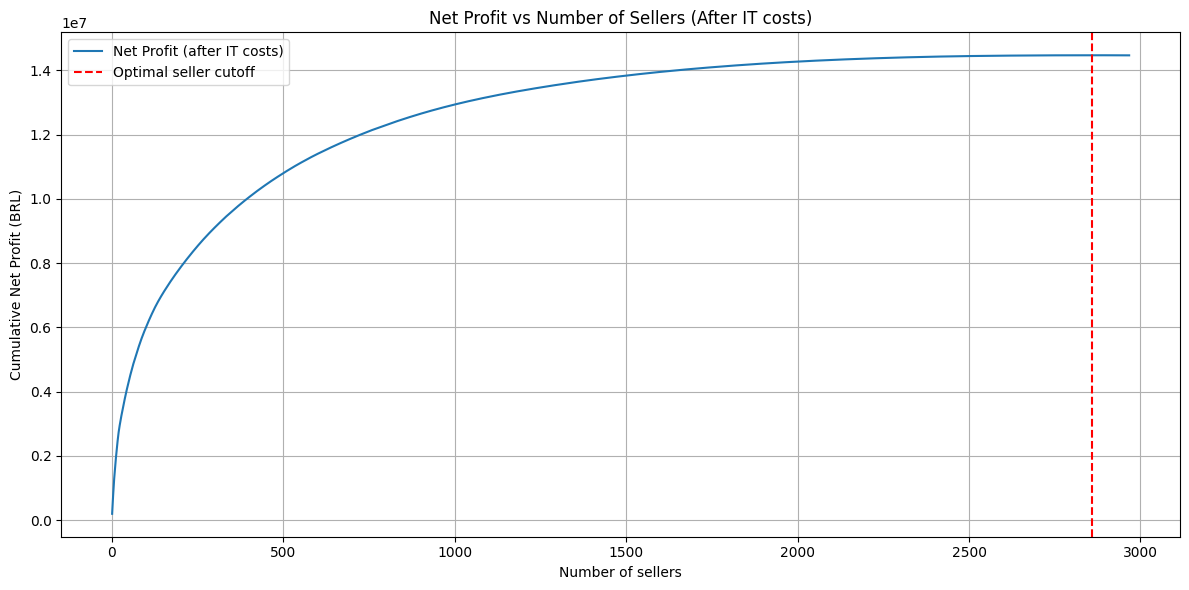

In [6]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(12,6))
plt.plot(df_sorted['cum_sellers'], df_sorted['net_profits'], label='Net Profit (after IT costs)')
plt.axvline(df_sorted['net_profits'].idxmax(), color='red', linestyle='--', label='Optimal seller cutoff')
plt.xlabel('Number of sellers')
plt.ylabel('Cumulative Net Profit (BRL)')
plt.title('Net Profit vs Number of Sellers (After IT costs)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [7]:
best_idx = df_sorted['net_profits'].idxmax()
best_row = df_sorted.loc[best_idx]
print("Optimal number of sellers to keep:", int(best_row['cum_sellers']))
print("Max net profit (after IT costs):", round(best_row['net_profits'], 2), "BRL")
print("Total revenues:", round(best_row['cum_revenues'], 2))
print("Total cost of reviews:", round(best_row['cum_cost_reviews'], 2))
print("Total IT costs:", round(best_row['it_costs'], 2))

Optimal number of sellers to keep: 2861
Max net profit (after IT costs): 14472719.72 BRL
Total revenues: 15004095.19
Total cost of reviews: 34664.36
Total IT costs: 496711.11


## 3. Investigate other Approaches 🕵️
*(optional)*

- Should Olist remove the worst performing products / categories from its marketplace entirely?
- Should Olist remove only consistently underperforming sellers, after a honeymoon period of a few months?
- Should Olist enforce sellers to include certain information on their product listings?
- Should Olist ask customers for purchase confirmation at certain times of day?
- Should Olist restrict seller/customer pairs between certain states to avoid delays?
- Should Olist acquire new sellers, with some cost assumptions to be suggested?
- ...


## Your turn!

🧺 Keep this notebook tidy! 

🗣 📊 You will present your insights to your favorite TA at the end of this `Communicate` unit 💪